This is self-contained notebook to illustrate difficulties I experienced, when started to learn fast.ai
They are described in https://medium.com/@ducha.aiki/fast-ai-library-1st-impression-958cb52afc

In [1]:
from fastprogress import master_bar, progress_bar
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
import pandas as pd
from torch import optim
import re
import torch
from fastai import *
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
import pretrainedmodels
from collections import OrderedDict
import math
import torchvision

SZ = 256
BS = 4
NUM_WORKERS = 4
SEED=0
LOAD_IF_CAN = True

name = f'TMP-{SZ}'

I will not use actual whale competition data, instead use provided MNIST subset

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
data = (ImageItemList.from_folder(path)
        .split_by_folder()          
        .label_from_folder()
        .transform(get_transforms(do_flip = False), size=SZ)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))


In [5]:
#Not really needed for illustration, but only two additional classes, lets keep them
class GeMConst(nn.Module):
    def __init__(self, p=3.74, eps=1e-6):
        super(GeMConst, self).__init__()
        self.p =p
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p) + ', ' + 'eps=' + str(
            self.eps) + ')'
def gem(x, p=3, eps=1e-5):
    return torch.abs(F.avg_pool2d(x.clamp(min=eps, max=1e4).pow(p), (x.size(-2), x.size(-1))).pow(1./p))

class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(-1).expand_as(x)
        return x

That is what my network head consists of: 4 branches, each of them sees only part on the input. 
Outputs are gathered in python list and are trained independently with separate cross-entropy losses, which helps against overfitting a lot.

Second output is also list: it contains activations from the pre-last layer to apply norm-regularization on them 


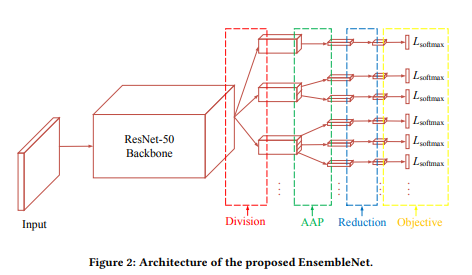
Image credit: https://arxiv.org/pdf/1901.05798.pdf

In [6]:
class PCBRingHead2(nn.Module):
    def __init__(self, num_classes, feat_dim, num_clf = 4, in_feat = 2048, r_init =1.5):
        super(PCBRingHead2,self).__init__()
        self.eps = 1e-10
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.num_clf = num_clf
        self.local_FE_list = nn.ModuleList()
        self.rings =  nn.ParameterList()
        self.total_clf = nn.Sequential( nn.Dropout(p=0.5),
                                      nn.Linear(in_features=feat_dim*num_clf,
                                                out_features=num_classes, bias=True))
        for i in range(num_clf):
            self.rings.append(nn.Parameter(torch.ones(1).cuda()*r_init))
        for i in range(num_clf):
            self.local_FE_list.append(nn.Sequential(GeMConst(3.74), Flatten(),
                        nn.BatchNorm1d(in_feat, eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True),
                        nn.Dropout(p=0.3),
                        nn.Linear(in_features=in_feat, out_features=feat_dim, bias=True),
                        nn.CELU(inplace=True),
                        nn.BatchNorm1d(feat_dim,eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True)
                        ))
        self.local_clf_list = nn.ModuleList()
        for i in range(num_clf):
            self.local_clf_list.append(nn.Sequential( nn.Dropout(p=0.5),
                                      nn.Linear(in_features=feat_dim, out_features=num_classes, bias=True)))
    def forward(self, x):
        assert x.size(3) % self.num_clf == 0
        stripe_w = int(x.size(2) // self.num_clf)
        local_feat_list = []
        local_preds_list = []
        for i in range(self.num_clf):
            local_feat = x[:, :, :, i * stripe_w: (i + 1) * stripe_w]
            local_feat_list.append(self.local_FE_list[i](local_feat))
            local_preds_list.append(self.local_clf_list[i](local_feat_list[i]))
        final_clf = self.total_clf(torch.cat(local_feat_list,dim=1).detach())
        local_preds_list.append(final_clf)
        return local_preds_list,local_feat_list

def MultiCE(x,targs):
    loss = None
    l = list(x)
    for i in range(len(l)):
        out = l[i]
        if loss is None:
            loss = CrossEntropyFlat()(out, targs)
        else:
            loss = loss+ CrossEntropyFlat()(out, targs)
    return loss

In [7]:
#Ring Loss ties activation norm to some (learned) value.
@dataclass
class RingLoss(Callback):
    "`Callback` that regroups lr adjustment to seq_len, AR and TAR."
    learn:Learner
    alpha:float=0.01
    def on_loss_begin(self, last_output:Tuple[list,list], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        self.feature_out = last_output[1]
        return last_output[0]

    def on_backward_begin(self,
                          last_loss:Rank0Tensor,
                          last_input:list,
                          last_target:Tensor,
                          **kwargs):
        x_list = self.feature_out
        ring_list = self.learn.model.head.rings
        num_clf = len(ring_list)
        loss = None
        for cc in range(num_clf):
            x = x_list[cc]
            R = ring_list[cc]
            x_norm = x.pow(2).sum(dim=1).pow(0.5)
            diff = torch.mean(torch.abs(x_norm - R.expand_as(x_norm))**2)
            if loss is None:
                loss = diff.mean()
            else:
                loss = loss + diff.mean()
        if self.alpha != 0.:  last_loss += (self.alpha * loss).sum()
        return last_loss


In [8]:
class CustomPCBNetwork(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = PCBRingHead2(5004, 512, 4, 512)
    def forward(self, x):
        x = self.cnn(x)
        preds, feats = self.head(x)
        return preds, feats

learn = Learner(data, CustomPCBNetwork(torchvision.models.vgg16_bn(pretrained=True)),
                   metrics=[],
                   loss_func=MultiCE,
                   callback_fns = [RingLoss])
learn.split([learn.model.cnn[26], learn.model.head])
learn.freeze()


Lets get some output from the network

In [7]:
for imgs, l in data.train_dl:
    break
print (imgs.shape)

torch.Size([64, 3, 256, 256])


In [8]:
with torch.no_grad():
    preds, feats = learn.model(imgs)

In [9]:
print (len(preds), len(feats))
for p in preds:
    print (p.size())
print ("Features")
for f in feats:
    print (f.size())


5 4
torch.Size([64, 5004])
torch.Size([64, 5004])
torch.Size([64, 5004])
torch.Size([64, 5004])
torch.Size([64, 5004])
Features
torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64, 512])


Now, try to use something from Ingerence tutorial https://docs.fast.ai/tutorial.inference.html

In [10]:
preds,y = learn.get_preds()

TypeError: expected Tensor as element 0 in argument 0, but got list

In [11]:
preds,y = learn.tta_only()

TypeError: expected Tensor as element 0 in argument 0, but got list

So I end up using following function instead

In [12]:
def get_predictions(model, loader):
    torch.cuda.empty_cache()
    model.eval()
    local_preds = []
    local_feats= []
    global_preds = []
    all_gt = []
    c= 0
    with torch.no_grad():
        for data1,label in loader:
            preds_list,feats_list = model(data1)
            global_preds.append(preds_list[-1].cpu())
            local_preds.append(torch.stack(preds_list[:-1],-1).cpu())
            all_gt.append(label.cpu())
            local_feats.append(L2Norm()(torch.cat(feats_list, dim=1)).cpu())
        global_preds = torch.cat(global_preds, dim=0).cpu()
        local_preds = torch.cat(local_preds, dim=0).cpu()
        local_feats = torch.cat(local_feats, dim=0).cpu()
        
        pred_clc = global_preds.max(dim=1)[1].cpu()
        all_gt = torch.cat(all_gt, dim=0).cpu()
        acc = (pred_clc==all_gt).float().mean().detach().cpu().item()
        out = f'acc = {acc:.3f}'
        print(out)
    return global_preds, all_gt,local_preds,local_preds


In [13]:
global_preds, all_gt,local_preds,local_preds =  get_predictions(learn.model, data.valid_dl)

acc = 0.000


And for test-time augmentation I used following random solution: switch train and val transforms

In [14]:
tranfsorms = get_transforms(do_flip = False)
tranfsorms_2 = (tranfsorms[1], tranfsorms[0])
data2 = (ImageItemList.from_folder(path)
        .split_by_folder()          
        .label_from_folder()
        .transform(tranfsorms_2, size=SZ)
        .databunch()
        .normalize(imagenet_stats))
data2.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data2.train_ds)
data2.train_dl.dl.batch_sampler.drop_last = False
data2.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data2.valid_ds)
data2.valid_dl.dl.batch_sampler.drop_last = False